# Pydata Okinawa #32
### Edwardで確率的プログラミング

コイン投げモデルをギブスサンプリングで近似してみる編

## おまけ
- "コイン投げ" の確率モデル（Beta-Bernoulliモデル）をEdwardで実装する
- 構築されたモデルと観測データをもとに、ギブスサンプリングで変分分布パラメータを真の分布に近似する

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from ipywidgets import interact

import numpy as np
import tensorflow as tf
import edward as ed
# ベータ分布とベルヌーイ分布をedwardから読み込む
from edward.models import Beta, Bernoulli, Empirical

In [2]:
ed.set_seed(42)

In [3]:
# 観測データが無い場合
#x_data = np.array([])

# 0ばかり観測された場合
# x_data = np.array([0] * 10)
x_data = np.array([0] * 50)

# 0と1が確率的に観測された場合
# n_data = 50
# np.random.seed(0)
# x_data = (np.random.rand(n_data) < 0.5).astype('int')

# コインを振った回数
N = len(x_data)

print("Number of tirals:\t%d" % N)
print("Observed data:\t", x_data)
if len(x_data) > 0:
    print("Mean value:\t%.3f" % x_data.mean())

Number of tirals:	50
Observed data:	 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
Mean value:	0.000


# コイン投げ Model を定義

In [4]:
# Beta-Bernoulliモデルを構築

# concentration1 = 1.0
# concentration0 = 1.0

concentration1 = 3.0
concentration0 = 2.0

p_mu = Beta(concentration1, concentration0, name='p_mu')
x = Bernoulli(probs=p_mu, sample_shape=N , name='x')

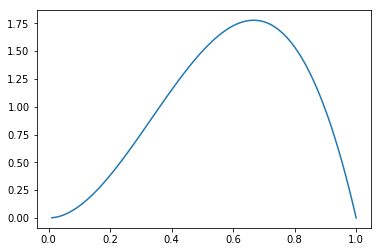

In [5]:
# 定義したBeta分布を定義してみる(事前分布)
sess = ed.get_session()
xs = np.linspace(0.01, 1.0, 100, dtype=np.float32)
pdf = p_mu.prob(xs).eval()
plt.plot(xs, pdf)
plt.show()
sess.close()

# ギブスサンプリングで推定する

In [6]:
n_sample = 500

q_mu = Empirical(tf.Variable(tf.zeros(n_sample)), name='q_mu')

In [7]:
inference = ed.Gibbs({p_mu: q_mu}, data={x: x_data})

逐次的に推定を実行する

In [8]:
inference.initialize()

sess = ed.get_session()
tf.global_variables_initializer().run()

t_ph = tf.placeholder(tf.int32, [])
running_cluster_means = tf.reduce_mean(q_mu.params[:t_ph], 0)

# iteration毎のパラメータを保存する
current_cluster_means = q_mu.params[t_ph]
all_current_culster_means = []

for i_iter in range(inference.n_iter):
    
    info_dict = inference.update()
    inference.print_progress(info_dict)
    all_current_culster_means.append(sess.run(current_cluster_means, {t_ph: i_iter-1}))
    
    # 100回に1度ログを書き出す
    if i_iter % 100 == 0:
        # curr_q_mu = q_mu.prob(mu_domain).eval()
        print("\nInferred cluster means:")
        print(sess.run(running_cluster_means, {t_ph: i_iter - 1}))

inference.finalize()

  1/500 [  0%]                                ETA: 102s | Acceptance Rate: inf
Inferred cluster means:
5.88619e-05
100/500 [ 20%] ██████                         ETA: 2s | Acceptance Rate: 1.010
Inferred cluster means:
0.0520519
200/500 [ 40%] ████████████                   ETA: 1s | Acceptance Rate: 1.000
Inferred cluster means:
0.0555399
300/500 [ 60%] ██████████████████             ETA: 0s | Acceptance Rate: 1.000
Inferred cluster means:
0.0558099
400/500 [ 80%] ████████████████████████       ETA: 0s | Acceptance Rate: 1.000
Inferred cluster means:
0.0556639
500/500 [100%] ██████████████████████████████ Elapsed: 1s | Acceptance Rate: 1.000


推定時にサンプリングされた値をヒストグラムにしてみる

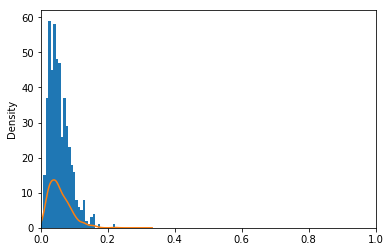

In [9]:
import pandas as pd

v = pd.Series(all_current_culster_means)
v.hist(bins=30)
v.plot(kind='kde', xlim=([0, 1.0]))

変分推定時の `q_mu` と同じような形になっている

In [10]:
x_data.mean()

0.0

In [11]:
np.array(all_current_culster_means).mean()

0.055898272

ヒストグラムをベータ分布にfitして分布のパラメータを確認する

In [12]:
from scipy.stats import beta

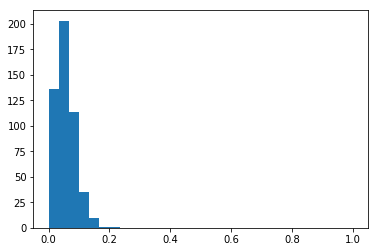

In [13]:
n, bins, patches = plt.hist(all_current_culster_means, bins = 30, range=[0,1])

/Users/t.nishime/.pyenv/versions/anaconda-2.4.0/envs/edward/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:412: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Users/t.nishime/.pyenv/versions/anaconda-2.4.0/envs/edward/lib/python3.5/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


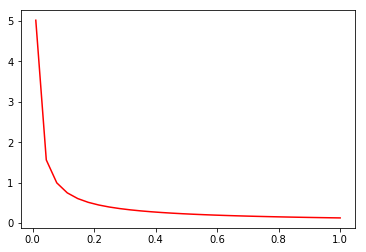

In [14]:
param = beta.fit(n)
x = np.linspace(0.01, 1.0, 30, dtype=np.float64)
pdf_fitted = beta.pdf(x, *param)
plt.plot(x, pdf_fitted, 'r')

In [15]:
param

(0.21511092231665169,
 197.57720233433915,
 -1.7785821852238525e-26,
 2583.3111660259328)